# GP demo

Oct 18 2019 MGS, M. Ansdell and G. V-D.


## Proviso:
### In this demo we model the Power Spectral Density (PSD) with a Gaussian Process (GP)
We **only** demo the model on **synthetic data** so far.  Next step will be real data, but we have to make sure the machinery works with fake data.

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from astropy.stats import LombScargle
import astropy.units as u
from astropy.time import Time

In [3]:
import celerite
from celerite import terms

In [4]:
import lightkurve as lk

## Kepler Prime Data

In [5]:
kepid = 757450

Retrieve all quarters of data from MAST online archive.

In [6]:
sr = lk.search_lightcurvefile('KIC {}'.format(kepid), mission='Kepler')
match_indices = [i for i, v in enumerate(sr.target_name) if str(kepid) in v]
lcfs = sr[match_indices].download_all()

Stitch all the quarters together using Pre-search Data Conditioning

In [7]:
lc_raw = lcfs.PDCSAP_FLUX.stitch(lambda lc: lc.normalize())

In [8]:
lc = lc_raw.remove_outliers(sigma=np.inf, sigma_lower=np.inf, sigma_upper=4)

Text(0.5, 1.0, 'Real data')

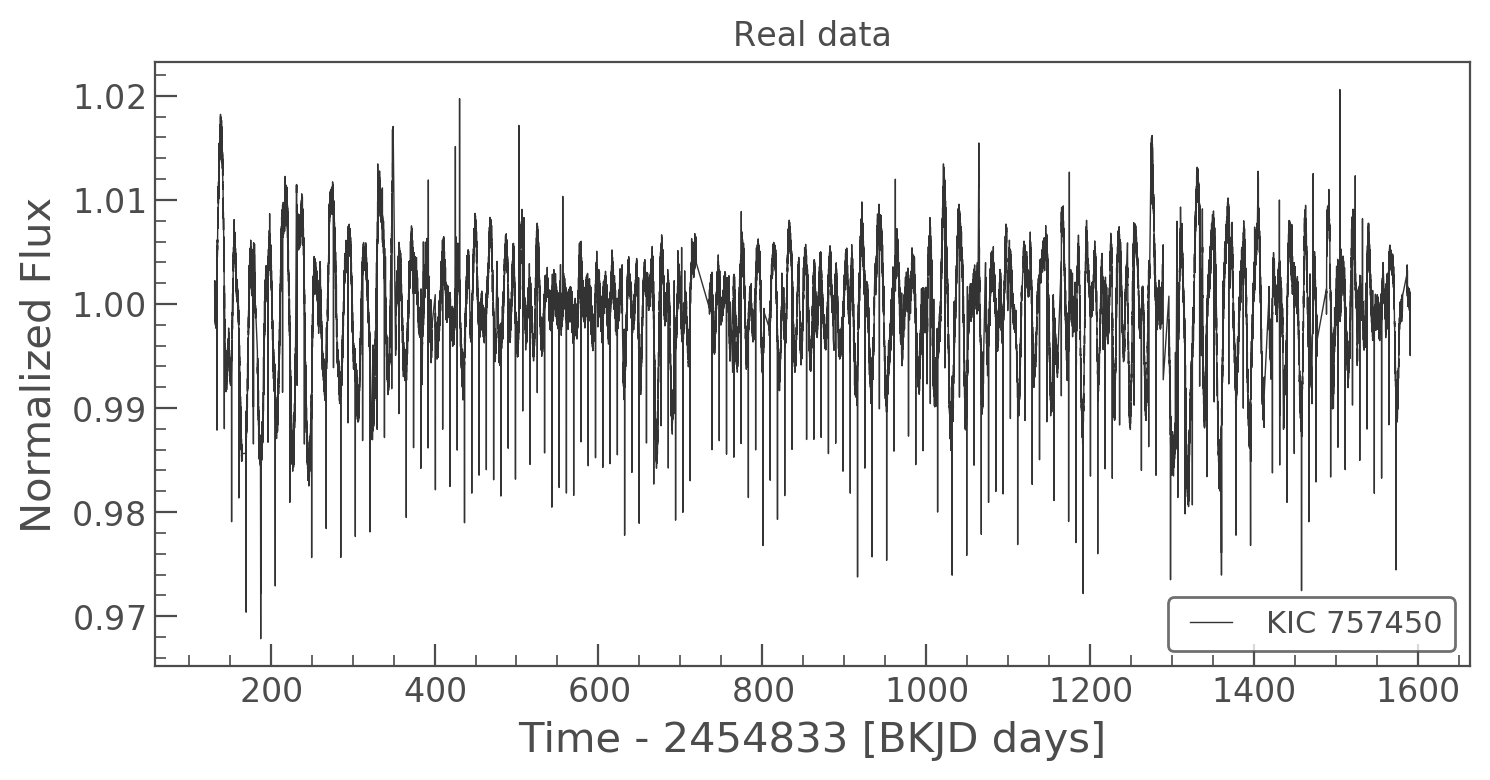

In [9]:
ax = lc.plot();
ax.set_title('Real data')

## Make the Power Spectrum

Let's create the power spectrum separately for each campaign.  This approach allows us to not worry about the mean level that we assign to each campaign, and it helps see which PSD structures persist from campaign to campaign.

In [10]:
pg = lc.normalize(unit='unscaled').to_periodogram(normalization='psd', freq_unit=1/u.day)

In [11]:
lc_noise = lc.copy()

In [12]:
lc_noise.flux = np.random.normal(1, scale=lc.flux_err)

In [13]:
pg_noise = lc_noise.normalize(unit='unscaled').to_periodogram(normalization='psd', freq_unit=1/u.day)

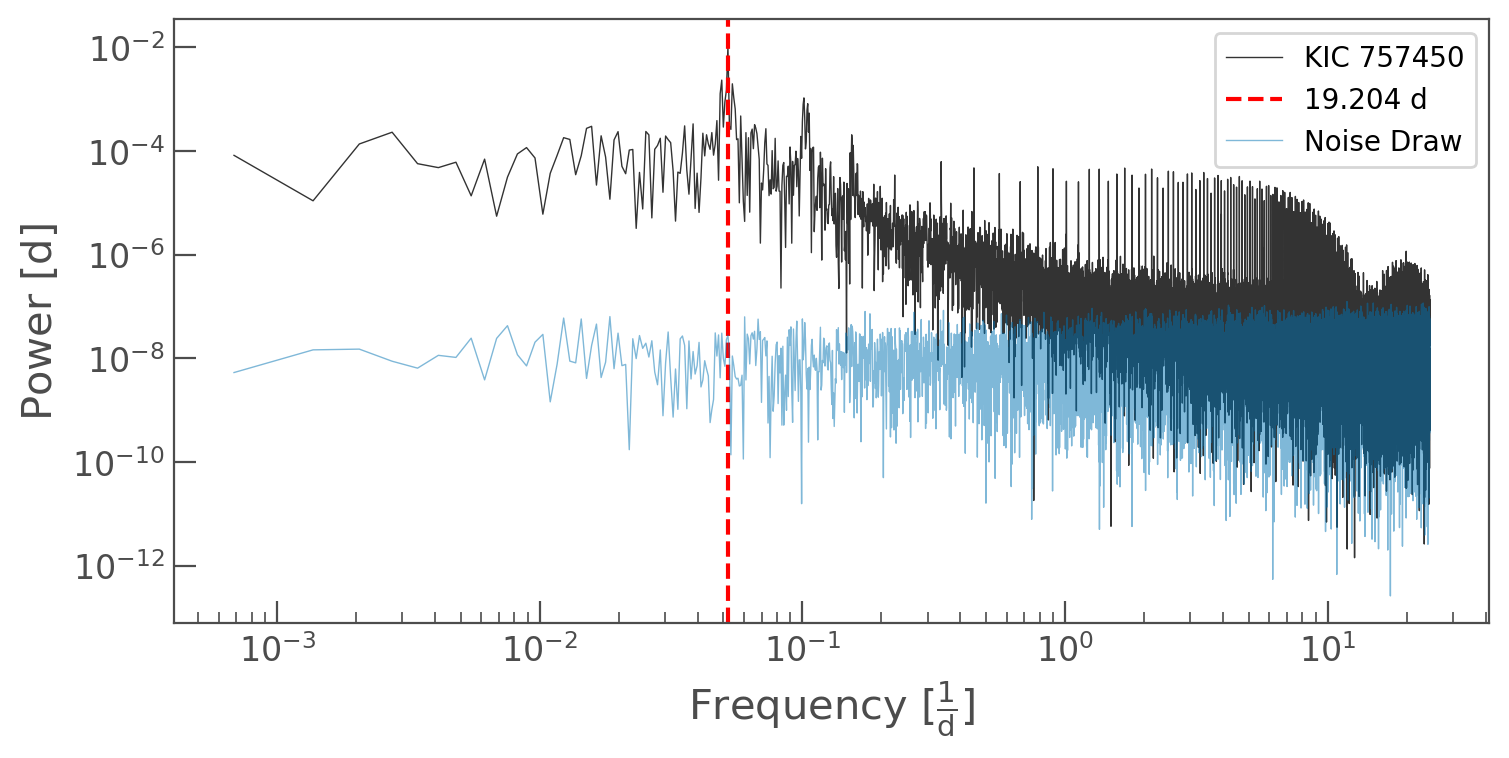

In [14]:
ax = pg.plot(scale='log')
ax.axvline(pg.frequency_at_max_power.value, color='r', linestyle='dashed', label='{:0.3f}'.format(pg.period_at_max_power.to(u.day)))
pg_noise.plot(ax=ax, scale='log', label='Noise Draw', alpha=0.5)
plt.legend();

The lightkurve power scale factor is:  
$$ \tilde P_{lk} = P_{lk} \cdot \frac{2 T}{N}$$

Where the tilde represents the rescaled, and  
$N$ is the number of samples  
$T$ is the total observation window duration, in say, days or $\frac{1}{\mathrm{Hz}}$

The *celerité* power scale **expects** a rescaling of Lomb Scargle power:
$$ \tilde P_{LS} = P_{LS} \cdot \frac{1}{N}$$  
*assuming* the `.get_psd()` power is scaled by $ \tilde P_c = P_c \cdot \frac{2}{T}$.

So to get them to match up, we can simply divide the lightkurve power by $2T$, **or** multiply the `celerite` power $\tilde P_c$ by $2T$, yielding: 

$ \hat P_c = \tilde P_c \cdot 2T = P_c \cdot \frac{2}{T}\cdot 2T =  4P_c $


My inclination is to leave lightkurve as perfect, and rescale celerite.

In [15]:
variance = np.var(lc.flux)

#### A periodic term

In [16]:
guess_period = pg.period_at_max_power.to(u.day).value
guess_period

19.203799917381684

In [17]:
Q_guess = 15.0
w0_guess = 2.0*np.pi / guess_period
S0_guess = variance /10

bounds1 = dict(log_S0=(np.log(variance/1000), np.log(variance*1000)),
               log_Q=(np.log(3), np.log(200)), 
               log_omega0=(np.log(w0_guess*0.8),np.log(w0_guess*1.2)))

kernel_sho = terms.SHOTerm(log_S0=np.log(S0_guess), log_Q=np.log(Q_guess), 
                       log_omega0=np.log(w0_guess), bounds=bounds1)

In [18]:
guess_period2 = guess_period /2

In [19]:
Q2_guess = 5.0
w02_guess = 2.0*np.pi / guess_period2
S02_guess = variance /100

bounds_sho2 = dict(log_S0=(np.log(variance/1000), np.log(variance*1000)),
               log_Q=(np.log(3), np.log(200)), 
               log_omega0=(np.log(w02_guess*0.8),np.log(w02_guess*1.2)))

kernel_sho2 = terms.SHOTerm(log_S0=np.log(S02_guess), log_Q=np.log(Q2_guess), 
                       log_omega0=np.log(w02_guess), bounds=bounds_sho2)

#### Compute the GP

In [20]:
net_kernel = kernel_sho + kernel_sho2
gp = celerite.GP(net_kernel, fit_mean=False, mean=lc.flux.mean())
gp.compute(lc.time, yerr=lc.flux_err)

In [21]:
f = pg.frequency #np.fft.rfftfreq(len(lc.time), lc.time[1] - lc.time[0])

In [22]:
power_true = net_kernel.get_psd(2*np.pi*f) * 4

In [23]:
flux_draw = gp.sample()

In [24]:
lc_draw = lc.copy()
lc_draw.flux = gp.sample()
pg_draw = lc_draw.normalize(unit='unscaled').to_periodogram(normalization='psd', freq_unit=1/u.day)

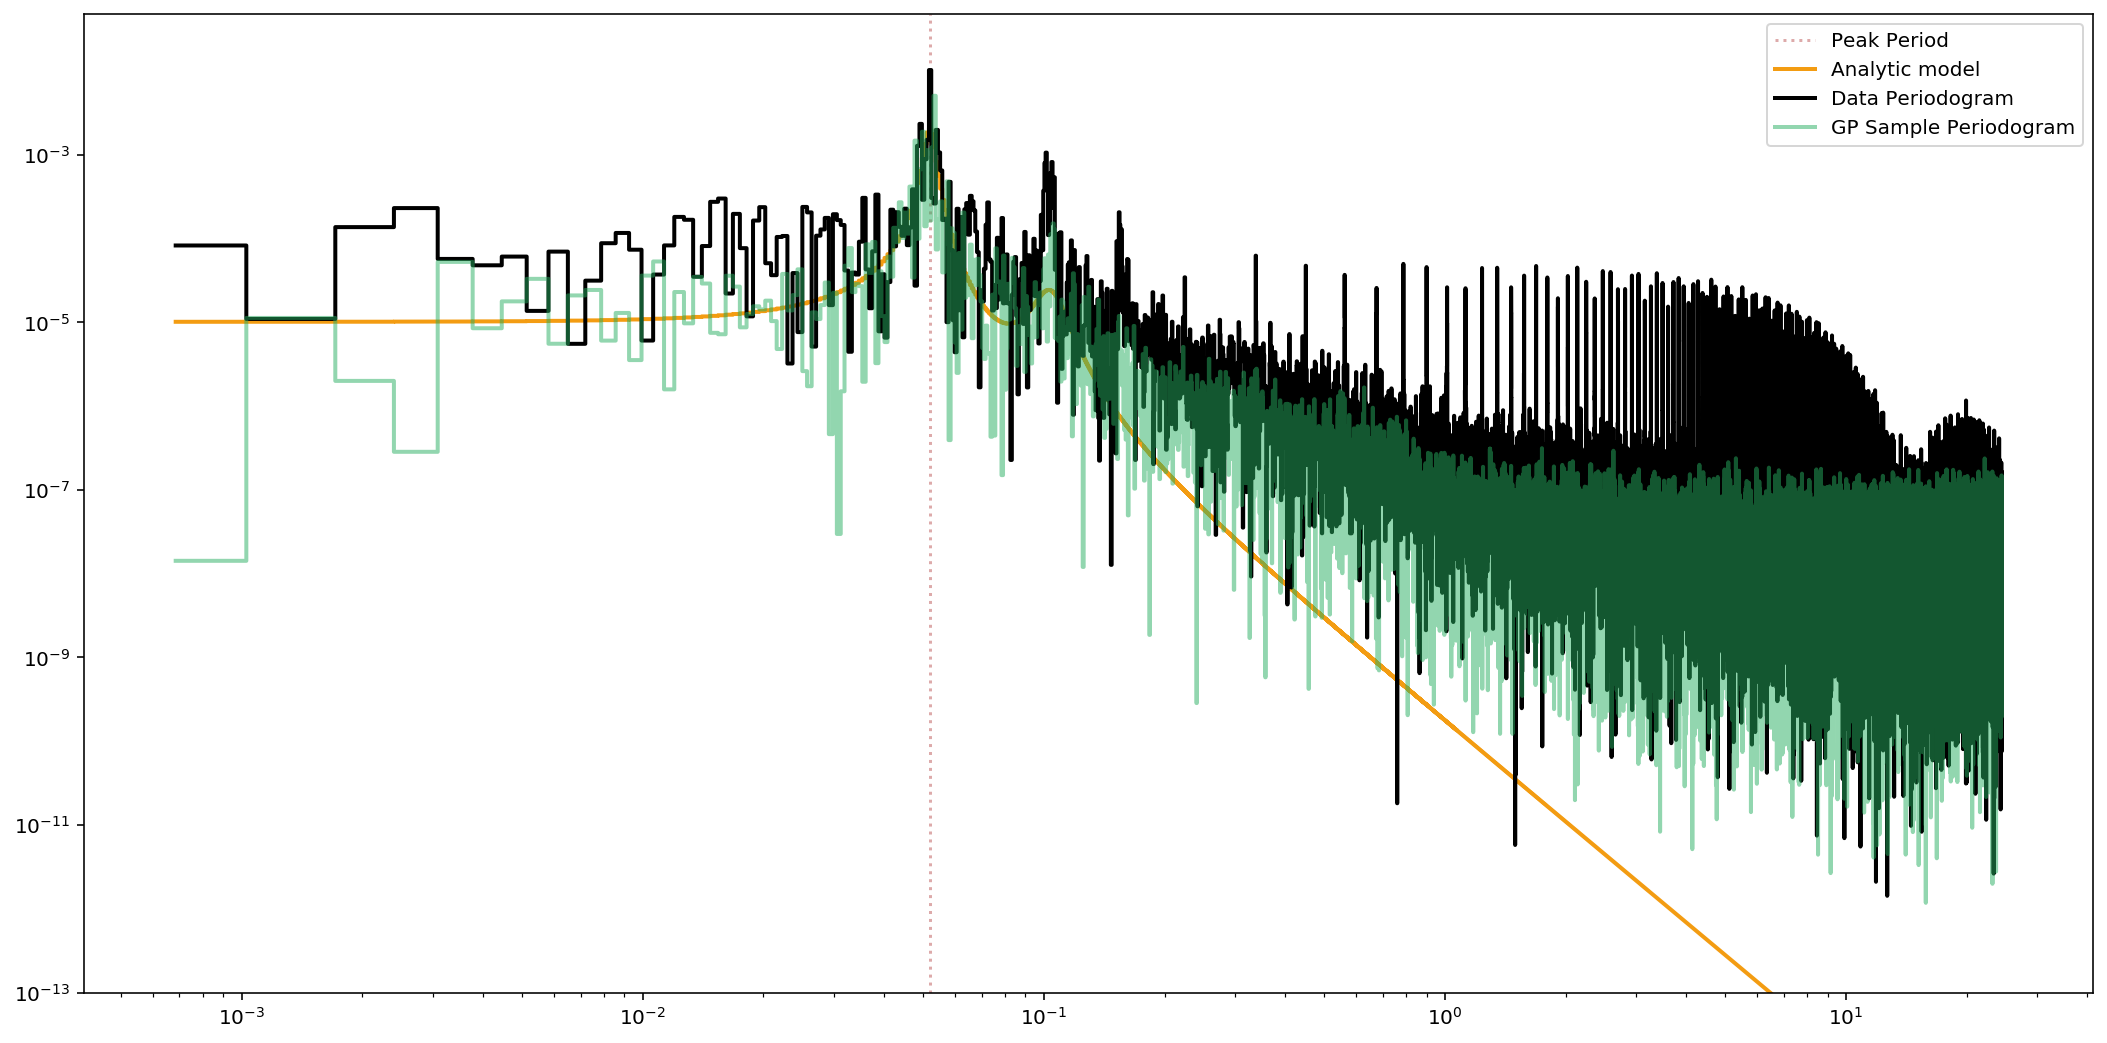

In [25]:
plt.figure(figsize=(18,9))

plt.axvline(1.0/guess_period, color='#ddaaaa', linestyle='dotted', label='Peak Period', alpha=1)

plt.step(f, power_true, color='#f39c12', lw=2,label="Analytic model", where='mid')

plt.step(pg.frequency.to(1/u.day), pg.power, color='k', lw=2,label="Data Periodogram", where='mid')
plt.step(pg_draw.frequency.to(1/u.day), pg_draw.power, color='#27ae60', lw=2, alpha=0.5,
         label="GP Sample Periodogram", where='mid')


plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-13)

plt.legend(loc='best');

Awesome!  Let's spot-check our results by making a draw from the model and then computing as if it were data.

# Optimize

In [26]:
true_params = gp.get_parameter_vector()

In [27]:
true_signal = gp.sample()
noise_draw = np.random.normal(loc=0, scale=lc.flux_err)
y_synthetic = true_signal + noise_draw

In [28]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

In [29]:
jitter = np.array([-2.0, 1.0, 0.05, -3, 2, -0.05])

In [30]:
initial_params = gp.get_parameter_vector() + jitter

In [31]:
from scipy.optimize import minimize

In [32]:
init_loglike = -1*neg_log_like(initial_params, y_synthetic, gp)
print("Initial log-likelihood: {0}".format(init_loglike))

Initial log-likelihood: 361365.21802825405


In [33]:
%%time
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y_synthetic, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

Final log-likelihood: 364155.4209854695
CPU times: user 24.4 s, sys: 1.45 s, total: 25.9 s
Wall time: 25.8 s


In [34]:
soln.nfev, soln.nit, soln.success

(35, 31, True)

In [35]:
np.exp(true_params - initial_params)

array([ 7.3890561 ,  0.36787944,  0.95122942, 20.08553692,  0.13533528,
        1.0512711 ])

In [36]:
np.exp(true_params - soln.x)

array([1.27861864, 0.93082762, 1.01491556, 0.2414231 , 1.66666667,
       1.10547801])

In [37]:
posterior_power = gp.kernel.get_psd(2*np.pi*f) * 4

In [38]:
%%time
y_many = gp.sample(size=20)

CPU times: user 80 ms, sys: 12.9 ms, total: 92.9 ms
Wall time: 91 ms


In [39]:
y_many.shape

(20, 64791)

In [40]:
lc_draw.flux = gp.sample()
pg_draw = lc_draw.normalize(unit='unscaled').to_periodogram(normalization='psd', freq_unit=1/u.day)

In [41]:
%%time
power_ls = []
for y0 in y_many:
    lc_draw.flux = y0
    pg_draw = lc_draw.to_periodogram(normalization='psd', freq_unit=1/u.day)
    power_ls.append(pg_draw.power.value)

power_ls = np.array(power_ls)

CPU times: user 9.28 s, sys: 344 ms, total: 9.62 s
Wall time: 2.44 s


In [42]:
lc_draw.flux = y_synthetic
pg_orig = lc_draw.to_periodogram(normalization='psd', freq_unit=1/u.day)

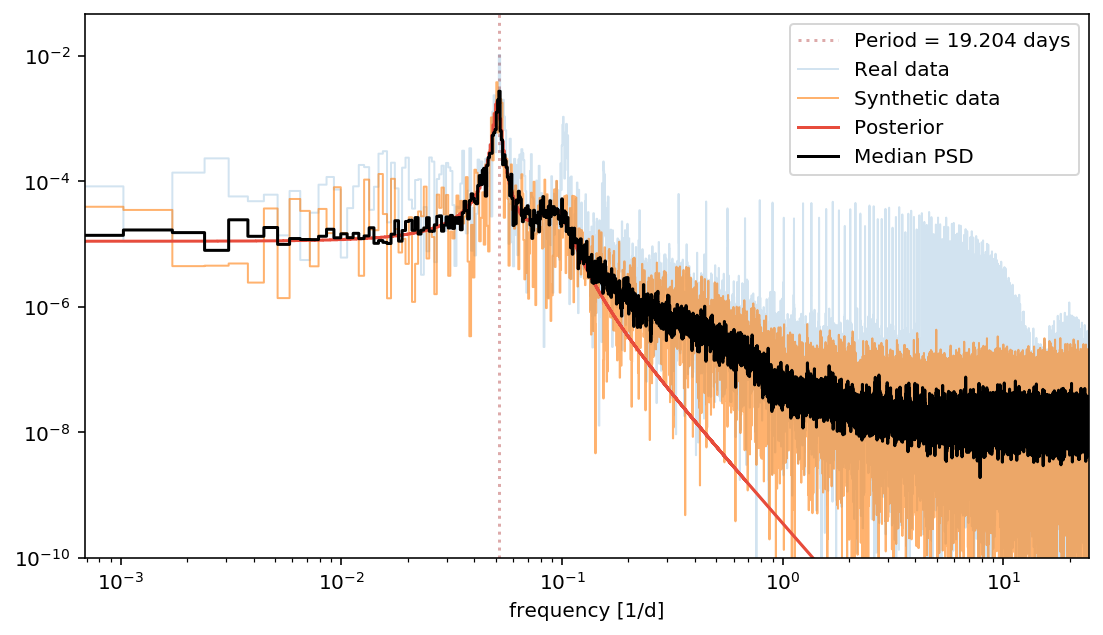

In [43]:
plt.figure(figsize=(9,5))

plt.axvline(pg.frequency_at_max_power.value, color='#ddaaaa', linestyle='dotted', 
            label='Period = {:0.3f} days'.format(pg.period_at_max_power.value), alpha=1)

plt.step(pg.frequency.value, pg.power.value, label="Real data", where='mid', alpha=0.2, lw=1)
plt.step(pg.frequency.value, pg_orig.power.value, label="Synthetic data", where='mid', alpha=0.6, lw=1)

plt.step(pg.frequency.value, posterior_power, color='#e74c3c', label ='Posterior')

plt.step(f.value, np.median(power_ls, axis=0), label="Median PSD", color='k', where='mid', alpha=1)

plt.yscale("log")
plt.xscale("log")
plt.xlim(f.value.min(), f.value.max())
plt.xlabel("frequency [1/d]")
plt.ylim(1e-10)

plt.legend(loc='best');

In [44]:
y_many.shape

(20, 64791)

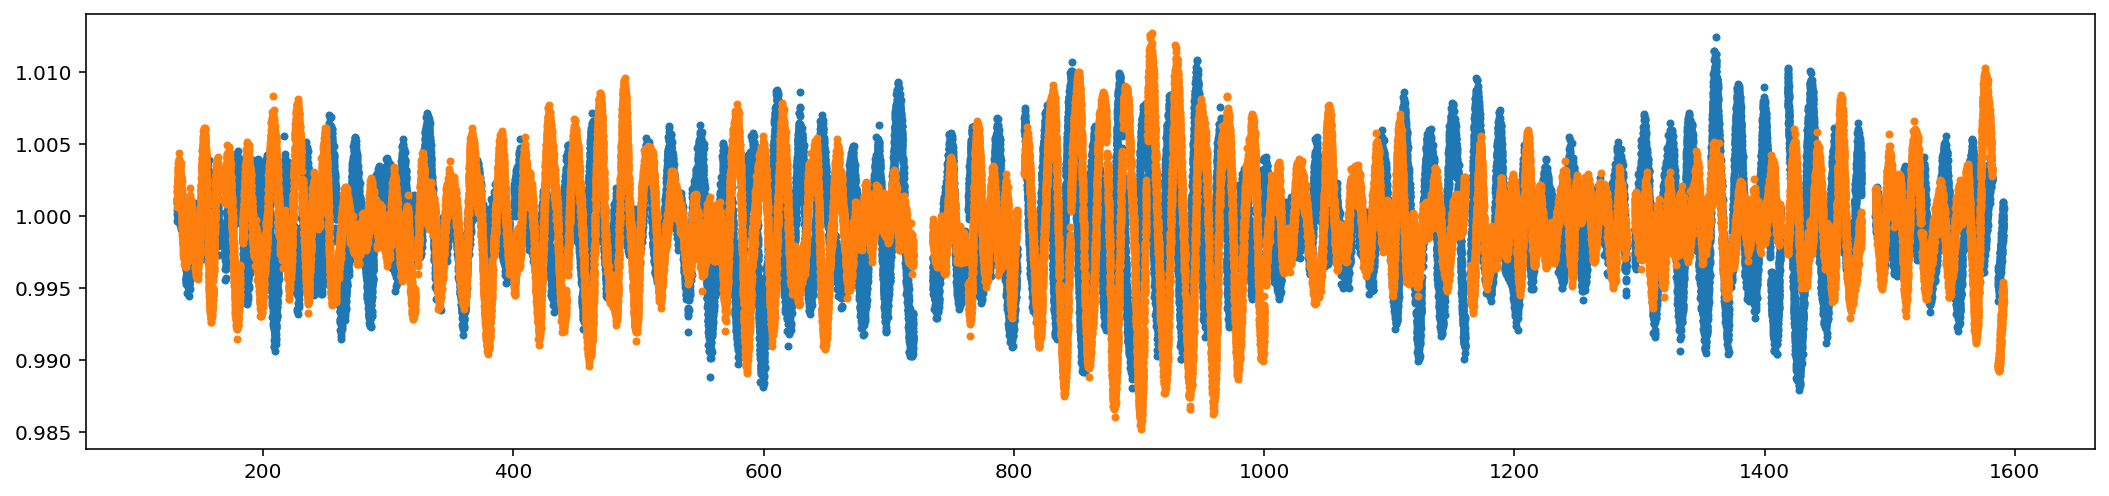

In [45]:
plt.figure(figsize=(18, 4))
plt.plot(lc.time, y_synthetic, '.')
plt.plot(lc.time, y_many[7, :], '.');

Same "family" of real and recovered.